# [Clustering trials](#clustering-trials)

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import string
from time import time
from IPython.display import display

import altair as alt
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from nltk.corpus import stopwords
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from spacy.lang.en.stop_words import STOP_WORDS

/home/elstand/Downloads/nlp-space-news-topic-modeling/.tox/ci/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
%aimport src.pipe_helpers
from src.pipe_helpers import TextCleaner

%aimport src.visualization_helpers
from src.visualization_helpers import altair_datetime_heatmap

In [4]:
SMALL_SIZE = 26
MEDIUM_SIZE = 28
BIGGER_SIZE = 30
plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["axes.facecolor"] = "white"
sns.set_style("darkgrid", {"legend.frameon": False})
sns.set_context("talk", font_scale=0.95, rc={"lines.linewidth": 2.5})

In [5]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
%matplotlib inline

<a id="toc"></a>

## [Table of Contents](#table-of-contents)
0. [About](#about)
1. [User Inputs](#user-inputs)
2. [Load joined data](#load-joined-data)
3. [Create clustering pipeline](#create-clustering-pipeline)
4. [Clustering](#clustering)
   - 4.1. [Analysis](#analysis)
   - 4.2. [Exploring clustering topics combined with source data](#exploring-clustering-topics-combined-with-source-data)
5. [LSA before clustering](#lsa-before-clustering)
   - 5.1. [Analysis](#analysis)
   - 5.2. [Exploring LSA-clustering topics combined with source data](#exploring-lsa-clustering-topics-combined-with-source-data)
6. [Conclusions](#conclusions)

<a id="about"></a>

## 0. [About](#about)

In this notebook, we will conduct experiments with the [`KMeans` clustering algorithm](https://en.wikipedia.org/wiki/K-means_clustering) to extract clusters from on the joined news listings data in `data/processed/*_processed.csv`.

The articles can be clustered by their topic, using a [bag of words model](https://en.wikipedia.org/wiki/Bag-of-words_model). Feature extraction will be done using [TFIDF vectorization](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). We can compare the determined clusters to the extracted topics found using NLP approaches in earlier notebooks.

<a id="user-inputs"></a>

## 1. [User Inputs](#user-inputs)

We'll define below the variables and helper functions that are to be used throughout the code.

In [6]:
PROJ_ROOT_DIR = os.path.abspath(os.getcwd())
processed_data_dir = os.path.join(PROJ_ROOT_DIR, "data", "processed")

In [7]:
# Dataset
publication_name = "guardian"

# Data locations
data_dir_path = os.path.join(processed_data_dir, f"{publication_name}_processed.csv")
cloud_run = True

# Custom stop words to include
manual_stop_words = ["nt", "ll", "ve"]

# Cluster naming
mapping_dict = {
    "guardian": {
        0: "Gravity and Black Holes - Hawking",
        1: "Shuttle Missions and Crashes",
        2: "Global Warming",
        3: "Academia 2",
        4: "Studying Comets and Meteors",
        5: "Rocket Launches - Testing",
        6: "Discover of Sub-Atomic particles",
        7: "Academia 1",
        8: "Planetary Research",
        9: "Imaging Stars - Astronomy",
        10: "Objects crashing into Earth",
        11: "Rocket Launches - Moon Landing",
        12: "Sky Watching",
        13: "ISS - USA and Russian segment",
        14: "Mars Exploration",
    }
}
mapping_dict_lsa = {
    "guardian": {
        0: "Academia 1",
        1: "Space Funding Bodies",
        2: "Studying Comets and Meteors",
        3: "Academia 2",
        4: "ISS - USA and Russian segment",
        5: "Shuttle Missions and Crashes",
        6: "Mars Exploration",
        7: "Planetary Research",
        8: "Imaging Stars - Astronomy",
        9: "Discover of Sub-Atomic particles",
        10: "Sky Watching",
        11: "Rocket Launches - Moon Landing",
        12: "Gravity and Black Holes - Hawking",
        13: "Rocket Launches - Testing",
        14: "Objects crashing into Earth",
    }
}

# General inputs
minibatch = False
kmeans_random_state = 42

In [8]:
# Parameters
publication_name = "guardian"
data_dir_path = "/home/elstand/Downloads/nlp-space-news-topic-modeling/data/processed/guardian_processed.csv"
cloud_run = True
manual_stop_words = ["nt", "ll", "ve"]
mapping_dict = {
    "guardian": {
        "0": "Gravity and Black Holes - Hawking",
        "1": "Shuttle Missions and Crashes",
        "2": "Global Warming",
        "3": "Academia 2",
        "4": "Studying Comets and Meteors",
        "5": "Rocket Launches - Testing",
        "6": "Discover of Sub-Atomic particles",
        "7": "Academia 1",
        "8": "Planetary Research",
        "9": "Imaging Stars - Astronomy",
        "10": "Objects crashing into Earth",
        "11": "Rocket Launches - Moon Landing",
        "12": "Sky Watching",
        "13": "ISS - USA and Russian segment",
        "14": "Mars Exploration",
    }
}
mapping_dict_lsa = {
    "guardian": {
        "0": "Academia 1",
        "1": "Space Funding Bodies",
        "2": "Studying Comets and Meteors",
        "3": "Academia 2",
        "4": "ISS - USA and Russian segment",
        "5": "Shuttle Missions and Crashes",
        "6": "Mars Exploration",
        "7": "Planetary Research",
        "8": "Imaging Stars - Astronomy",
        "9": "Discover of Sub-Atomic particles",
        "10": "Sky Watching",
        "11": "Rocket Launches - Moon Landing",
        "12": "Gravity and Black Holes - Hawking",
        "13": "Rocket Launches - Testing",
        "14": "Objects crashing into Earth",
    }
}
minibatch = False
kmeans_random_state = 42


In [9]:
mapping_dict[publication_name] = {int(k): v for k, v in mapping_dict[publication_name].items() if type(k) != int}
mapping_dict_lsa[publication_name] = {int(k): v for k, v in mapping_dict_lsa[publication_name].items() if type(k) != int}

In [10]:
# Get stop words from all packages
# NLTK
nltk_dir = os.path.join(os.path.expanduser("~"), "nltk_data")
if not os.path.isdir(nltk_dir) or cloud_run:
    nltk.download("punkt")
    nltk.download("wordnet")
    nltk.download("stopwords")
    nltk.download("averaged_perceptron_tagger")
nltk_stop_words = set(stopwords.words("english"))
# Spacy and sklearn
spacy_stop_words = STOP_WORDS
sklearn_stop_words = stop_words.ENGLISH_STOP_WORDS

# Assemble manual list of stop words
spacy_not_in_sklearn = set(spacy_stop_words) - set(sklearn_stop_words)
nltk_not_in_sklearn = set(nltk_stop_words) - set(sklearn_stop_words)
all_stop_words = set(
    list(set(sklearn_stop_words))
    + list(spacy_not_in_sklearn)
    + list(nltk_not_in_sklearn)
)

# Manually add to stop words
for manual_stop_word in manual_stop_words:
    all_stop_words.add(manual_stop_word)

[nltk_data] Downloading package punkt to /home/elstand/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/elstand/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/elstand/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/elstand/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [11]:
def preprocessing(line):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    return line

<a id="load-joined-data"></a>

## 2. [Load joined data](#load-joined-data)

As with the previous notebooks, we'll start by loading the joined data from from a publication, stored at `data/processed/<publication-name>_processed.csv`, into a `DataFrame`

In [12]:
df = pd.read_csv(data_dir_path)
df = df[["text", "year"]]
display(df.head())

,text,year
0,The second Russian satellite has demonstrated ...,1957
1,"Col. Glenn reported ""hale and hearty""Picked up...",1962
2,The entire three-man crew of the Apollo One sp...,1967
3,Russia's celebratory gesture in manned space f...,1967
4,Men are on the moon. At 3 39 a.m. this morning...,1969


In [13]:
corpus_raw = df.loc[:, "text"].values.tolist()

<a id="create-clustering-pipeline"></a>

## 3. [Create clustering pipeline](#create-clustering-pipeline)

Next, we'll define the a clustering pipeline using the [`KMeans` clustering algorithm](https://en.wikipedia.org/wiki/K-means_clustering)

In [14]:
if minibatch:
    km = MiniBatchKMeans(
        n_clusters=len(mapping_dict[publication_name]),
        init="k-means++",
        n_init=10,
        init_size=3000,
        batch_size=3000,
        verbose=False,
        random_state=kmeans_random_state,
    )
else:
    km = KMeans(
        n_clusters=len(mapping_dict[publication_name]),
        init="k-means++",
        max_iter=500,
        n_init=10,
        verbose=False,
        random_state=kmeans_random_state,
    )
vectorizer = TfidfVectorizer(
    tokenizer=None,
    preprocessor=preprocessing,
    stop_words=all_stop_words,  # "all_stop_words" or "english"
    lowercase=True,
    ngram_range=(1, 1),
    max_df=1.0,
    min_df=1,
    max_features=None,
    binary=False,
    strip_accents="ascii",
    token_pattern="[a-z][a-z]+",
)
pipe = Pipeline(
    steps=[
        ("cleaner", TextCleaner(split=False)),
        ("vectorizer", vectorizer),
        ("kmeans", km),
    ]
)

<a id="clustering"></a>

## 4. [Clustering](#clustering)

<a id="analysis"></a>

### 4.1. [Analysis](#analysis)

Next, we'll use the clustering analysis pipeline to cluster the documents in the corpus

In [15]:
cell_st = time()

_ = pipe.fit_transform(corpus_raw)
X_vectors = pipe.named_steps["vectorizer"].transform(corpus_raw)
silhouette_score_calc = silhouette_score(
    X_vectors, pipe.named_steps["kmeans"].labels_, sample_size=df.shape[0]
)
print(f"Silhouette Coefficient: {silhouette_score_calc:.3f}")

total_minutes, total_seconds = divmod(time() - cell_st, 60)
print(
    f"Cell exection time: {int(total_minutes):d} minutes, {total_seconds:.2f} seconds"
)

Silhouette Coefficient: 0.015
Cell exection time: 0 minutes, 33.42 seconds


Below, are the top 10 terms per cluster created

In [16]:
print(f"Top terms per cluster, using random_state={kmeans_random_state}:")
order_centroids = pipe.named_steps["kmeans"].cluster_centers_.argsort()[:, ::-1]
terms = pipe.named_steps["vectorizer"].get_feature_names()
for i in range(len(mapping_dict[publication_name])):
    print(f"Cluster {i:0d}:", end="")
    for ind in order_centroids[i, :10]:
        print(f" {terms[ind]}", end="")
    print()

Top terms per cluster, using random_state=42:


Cluster 0: stars telescope black galaxies universe galaxy star light hubble gravitational
Cluster 1: shuttle space nasa launch station astronauts columbia mission crew said
Cluster 2: climate life ice change earth water carbon warming global scientists
Cluster 3: brain cells brains memory people memories body human patients neurons
Cluster 4: comet rosetta philae comets lander dust mission sun surface solar
Cluster 5: space rocket launch satellites satellite spacex flight said company orbit
Cluster 6: universe particles particle higgs matter theory physics dark lhc energy
Cluster 7: science space people research said new like says time world
Cluster 8: solar sun pluto planet earth spacecraft venus cassini planets said
Cluster 9: planets planet star stars kepler life astronomers habitable telescope earth
Cluster 10: asteroid asteroids earth impact space hit spacecraft rock eros object
Cluster 11: moon lunar space apollo armstrong moons mission nasa astronauts surface
Cluster 12: eclipse

The clusters are shown below, for the pre-determined choice of `random_state` of `42` specified in the `KMeans` clustering algorithm above

```
Top terms per cluster, using random_state=42:
Cluster 0: stars telescope black galaxies universe galaxy star light hubble gravitational
Cluster 1: shuttle space nasa launch station astronauts columbia mission crew said
Cluster 2: climate life ice change earth water carbon warming global scientists
Cluster 3: brain cells brains memory people memories body human patients neurons
Cluster 4: comet rosetta philae comets lander dust mission sun surface solar
Cluster 5: space rocket launch satellites satellite spacex flight said company orbit
Cluster 6: universe particles particle higgs matter theory physics dark lhc energy
Cluster 7: science space people research said new like says time world
Cluster 8: solar sun pluto planet earth spacecraft venus cassini planets said
Cluster 9: planets planet star stars kepler life astronomers habitable telescope earth
Cluster 10: asteroid asteroids earth impact space hit spacecraft rock eros object
Cluster 11: moon lunar space apollo armstrong moons mission nasa astronauts surface
Cluster 12: eclipse iss shadow evening predictions asterisks moon directions earths sky
Cluster 13: station space mir russian crew peake astronaut said astronauts iss
Cluster 14: mars martian planet life mission rover water surface lander said
```

**Observations**
1. Generally, these divisions/clusters are similar to those found in the NMF (`sklearn`) or CorEx approaches.
2. One notable exception is that none of the clusters correspond to the topic `Space Funding Bodies`. Analysis of the number of occurrences of this as the most popular topic, over the decades, is not possible.
   - in its place is `Sky Watching`, which is very similar to `Imaging Stars - Astronomy`
3. The `Saturn Research` topic appears to have been merged into `Academia` - the research element is a common theme in both and is likely driving this combination.

The [distance of each document from its associated cluster center](https://stackoverflow.com/questions/54240144/distance-between-nodes-and-the-centroid-in-a-kmeans-cluster/54247525#54247525) is shown below

In [17]:
cell_st = time()

X_dist = pipe.named_steps["kmeans"].fit_transform(X_vectors) ** 2
df["sqdist"] = pd.Series(X_dist.sum(axis=1).round(2))
display(df.head(10))

total_minutes, total_seconds = divmod(time() - cell_st, 60)
print(
    f"Cell exection time: {int(total_minutes):d} minutes, {total_seconds:.2f} seconds"
)

,text,year,sqdist
0,The second Russian satellite has demonstrated ...,1957,15.58
1,"Col. Glenn reported ""hale and hearty""Picked up...",1962,16.08
2,The entire three-man crew of the Apollo One sp...,1967,15.76
3,Russia's celebratory gesture in manned space f...,1967,15.86
4,Men are on the moon. At 3 39 a.m. this morning...,1969,15.62
5,Men are on the moon. At 3:39 am this morning -...,1969,15.66
6,The three astronauts in the stricken Apollo 13...,1970,15.67
7,The outlook for manned space flights looks ble...,1971,15.68
8,The American space programme has ground to a s...,1986,15.47
9,Space tragedies either unfold behind the impen...,1986,16.09


Cell exection time: 0 minutes, 18.48 seconds


We'll now [add](https://stackoverflow.com/a/50804098/4057186) the topic name (names assigned to each cluster, based on its component terms) found, to each document the above as a separate column

In [18]:
# Get indices of points for each cluster
cluster_topic_name_mapper_dict = {
    k: np.where(pipe.named_steps["kmeans"].labels_ == k)[0].tolist()
    for k in range(pipe.named_steps["kmeans"].n_clusters)
}
# Replace cluster indices by manually determined names
df["most_popular_topic"] = np.nan
for k, v in cluster_topic_name_mapper_dict.items():
    df.loc[v, "most_popular_topic"] = mapping_dict[publication_name][k]
display(df.head(10))

,text,year,sqdist,most_popular_topic
0,The second Russian satellite has demonstrated ...,1957,15.58,ISS - USA and Russian segment
1,"Col. Glenn reported ""hale and hearty""Picked up...",1962,16.08,ISS - USA and Russian segment
2,The entire three-man crew of the Apollo One sp...,1967,15.76,ISS - USA and Russian segment
3,Russia's celebratory gesture in manned space f...,1967,15.86,Studying Comets and Meteors
4,Men are on the moon. At 3 39 a.m. this morning...,1969,15.62,Global Warming
5,Men are on the moon. At 3:39 am this morning -...,1969,15.66,Global Warming
6,The three astronauts in the stricken Apollo 13...,1970,15.67,Global Warming
7,The outlook for manned space flights looks ble...,1971,15.68,Studying Comets and Meteors
8,The American space programme has ground to a s...,1986,15.47,Imaging Stars - Astronomy
9,Space tragedies either unfold behind the impen...,1986,16.09,Rocket Launches - Moon Landing


<a id="exploring-clustering-topics-combined-with-source-data"></a>

### 4.2. [Exploring clustering topics combined with source data](#exploring-clustering-topics-combined-with-source-data)

Here, we will show a heatmap of the most popular topic by year

In [19]:
topics_by_timeframe = (
    df.groupby(["most_popular_topic", "year"])
    .size()
    .reset_index()
    .sort_values(by=["most_popular_topic", 0, "year"], ascending=False)
    .rename(columns={0: "count"})
)
display(topics_by_timeframe.head())

,most_popular_topic,year,count
285,Studying Comets and Meteors,2000,38
284,Studying Comets and Meteors,1999,24
286,Studying Comets and Meteors,2001,16
288,Studying Comets and Meteors,2003,13
301,Studying Comets and Meteors,2016,9


In [20]:
altair_datetime_heatmap(
    topics_by_timeframe,
    x="year:O",
    y="most_popular_topic:N",
    xtitle="Year",
    ytitle="Most popular topic",
    tooltip=[
        {"title": "Year", "field": "year", "type": "ordinal",},
        {
            "title": "Most popular topic",
            "field": "most_popular_topic",
            "type": "nominal",
        },
        {
            "title": "Number of occurrences as main topic",
            "field": "count",
            "type": "quantitative",
        },
    ],
    cmap="yelloworangered",
    legend_title="",
    color_by_col="count:Q",
    yscale="log",
    axis_tick_font_size=12,
    axis_title_font_size=16,
    title_font_size=20,
    legend_fig_padding=10,  # default is 18
    y_axis_title_alignment="left",
    fwidth=700,
    fheight=450,
    file_path=os.path.join(PROJ_ROOT_DIR, "reports", "figures", "my_heatmap.html"),
    save_to_html=False,
    sort_y=[],
    sort_x=[],
)

alt.LayerChart(...)

<a id="lsa-before-clustering"></a>

## 5. [LSA before clustering](#lsa-before-clustering)

Latent Semantic Analysis (LSA) is Signular Value Decomposition (SVD) applied to Natural Language Processing (NLP).

Below is a preliminary attempt at implementing this, before `KMeans` clustering, to obtain topics after TFIDF vectorization of the documents. This will be done using [Truncated SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition) in the `sklearn` Python library.

<a id="analysis"></a>

### 5.1. [Analysis](#analysis)

We'll instantiate a new pipeline to support LSA before `KMeans` clustering
- the only change here is to add a SVD step before the clustering step

In [21]:
pipe_trunc_svd = Pipeline(
    steps=[
        ("cleaner", TextCleaner(split=False)),
        ("vectorizer", vectorizer),
        (
            "svd",
            TruncatedSVD(
                len(mapping_dict[publication_name]), random_state=kmeans_random_state
            ),
        ),
        ("kmeans", km),
    ]
)

Next, we'll use the LSA+clustering analysis pipeline to cluster the documents in the corpus

In [22]:
cell_st = time()

_ = pipe_trunc_svd.fit_transform(corpus_raw)

total_minutes, total_seconds = divmod(time() - cell_st, 60)
print(
    f"Cell exection time: {int(total_minutes):d} minutes, {total_seconds:.2f} seconds"
)

Cell exection time: 0 minutes, 11.91 seconds


Below, are the top 10 terms per cluster created

In [23]:
original_space_centroids = pipe_trunc_svd.named_steps["svd"].inverse_transform(
    pipe_trunc_svd.named_steps["kmeans"].cluster_centers_
)
print(f"Top terms per cluster, using random_state={kmeans_random_state}:")
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = pipe_trunc_svd.named_steps["vectorizer"].get_feature_names()
for i in range(len(mapping_dict[publication_name])):
    print(f"Cluster {i:0d}:", end="")
    for ind in order_centroids[i, :10]:
        print(f" {terms[ind]}", end="")
    print()

Top terms per cluster, using random_state=42:


Cluster 0: science people research like says new world brain scientists scientific
Cluster 1: space said science satellites uk satellite launch nasa station mission
Cluster 2: comet rosetta philae comets lander dust mission surface sun solar
Cluster 3: space science people says said like life time earth brain
Cluster 4: station space mir russian crew iss astronauts said astronaut international
Cluster 5: shuttle nasa space launch station astronauts mission columbia crew said
Cluster 6: mars martian life planet mission water surface rover lander nasa
Cluster 7: pluto planet solar cassini moon spacecraft planets saturn titan moons
Cluster 8: planets planet stars star telescope life astronomers solar earth kepler
Cluster 9: higgs particle particles matter lhc universe physics dark energy boson
Cluster 10: sun solar earth space satellites eclipse satellite planet orbit atmosphere
Cluster 11: moon lunar space apollo nasa astronauts mission moons earth surface
Cluster 12: universe stars blac

The clusters are shown below, for the pre-determined choice of `random_state` of `42` specified in both the truncated SVD and `KMeans` clustering algorithm above

```
Top terms per cluster, using random_state=42:
Cluster 0: science people research like says new world brain scientists scientific
Cluster 1: space said science satellites uk satellite launch nasa station mission
Cluster 2: comet rosetta philae comets lander dust mission surface sun solar
Cluster 3: space science people says said like life time earth brain
Cluster 4: station space mir russian crew iss astronauts said astronaut international
Cluster 5: shuttle nasa space launch station astronauts mission columbia crew said
Cluster 6: mars martian life planet mission water surface rover lander nasa
Cluster 7: pluto planet solar cassini moon spacecraft planets saturn titan moons
Cluster 8: planets planet stars star telescope life astronomers solar earth kepler
Cluster 9: higgs particle particles matter lhc universe physics dark energy boson
Cluster 10: sun solar earth space satellites eclipse satellite planet orbit atmosphere
Cluster 11: moon lunar space apollo nasa astronauts mission moons earth surface
Cluster 12: universe stars black galaxies telescope gravitational matter dark light waves
Cluster 13: space rocket launch spacex flight company musk rockets said virgin
Cluster 14: asteroid asteroids earth impact space rock object collision comet said
```

**Observations**
1. The `Space Funding Bodies` topic reappears, but is not as strongly defined (in terms of its component terms) as in NMF/CorEx approaches.
2. Two clusters may be combined
   - `Academia 1,2`
     - the Saturn Research topic might been replaced by one of these
   - `Sky watching` and `Imaging Stars - Astronomy`
     - possibly one of these has replaced `Global Warming` from the NMF/CorEx approaches

The percent variance explained by the truncated SVD is calculated below

In [24]:
explained_variance = pipe_trunc_svd.named_steps["svd"].explained_variance_ratio_.sum()
print(f"Explained variance of the SVD step: {int(explained_variance * 100)}%")

Explained variance of the SVD step: 6%


**Observations**
1. Since the SVD only accounts for 6% of the variance, hyperparameter optimization of all steps in the pipeline should be pursued.
   - it is reassuring that the majority of topics reappear despite this (possibly excessively) strong degree of dimensionality reduction

The distance of each document from its associated cluster center is shown below

In [25]:
cell_st = time()

X_dist = pipe.named_steps["kmeans"].fit_transform(X_vectors) ** 2
df["sqdist"] = pd.Series(X_dist.sum(axis=1).round(2))

total_minutes, total_seconds = divmod(time() - cell_st, 60)
print(
    f"Cell exection time: {int(total_minutes):d} minutes, {total_seconds:.2f} seconds"
)

Cell exection time: 0 minutes, 18.59 seconds


<a id="exploring-lsa-clustering-topics-combined-with-source-data"></a>

### 5.2. [Exploring LSA-clustering topics combined with source data](#exploring-lsa-clustering-topics-combined-with-source-data)

Below, we add a topic name (names assigned to each cluster, based on its component terms), to each document above as a separate column

In [26]:
# Get indices of points for each cluster
cluster_topic_name_mapper_dict = {
    k: np.where(pipe.named_steps["kmeans"].labels_ == k)[0].tolist()
    for k in range(pipe.named_steps["kmeans"].n_clusters)
}
# Replace cluster indices by manually determined names
df["most_popular_topic"] = np.nan
for k, v in cluster_topic_name_mapper_dict.items():
    df.loc[v, "most_popular_topic"] = mapping_dict_lsa[publication_name][k]
display(df.head(10))

,text,year,sqdist,most_popular_topic
0,The second Russian satellite has demonstrated ...,1957,15.58,Rocket Launches - Testing
1,"Col. Glenn reported ""hale and hearty""Picked up...",1962,16.08,Rocket Launches - Testing
2,The entire three-man crew of the Apollo One sp...,1967,15.76,Rocket Launches - Testing
3,Russia's celebratory gesture in manned space f...,1967,15.86,ISS - USA and Russian segment
4,Men are on the moon. At 3 39 a.m. this morning...,1969,15.62,Studying Comets and Meteors
5,Men are on the moon. At 3:39 am this morning -...,1969,15.66,Studying Comets and Meteors
6,The three astronauts in the stricken Apollo 13...,1970,15.67,Studying Comets and Meteors
7,The outlook for manned space flights looks ble...,1971,15.68,ISS - USA and Russian segment
8,The American space programme has ground to a s...,1986,15.47,Discover of Sub-Atomic particles
9,Space tragedies either unfold behind the impen...,1986,16.09,Rocket Launches - Moon Landing


As before, we will show a heatmap of the most popular topic by year

In [27]:
topics_by_timeframe = (
    df.groupby(["most_popular_topic", "year"])
    .size()
    .reset_index()
    .sort_values(by=["most_popular_topic", 0, "year"], ascending=False)
    .rename(columns={0: "count"})
)
display(topics_by_timeframe.head())

,most_popular_topic,year,count
303,Studying Comets and Meteors,2019,34
293,Studying Comets and Meteors,2009,19
302,Studying Comets and Meteors,2018,17
296,Studying Comets and Meteors,2012,14
283,Studying Comets and Meteors,1999,14


In [28]:
altair_datetime_heatmap(
    topics_by_timeframe,
    x="year:O",
    y="most_popular_topic:N",
    xtitle="Year",
    ytitle="Most popular topic",
    tooltip=[
        {"title": "Year", "field": "year", "type": "ordinal",},
        {
            "title": "Most popular topic",
            "field": "most_popular_topic",
            "type": "nominal",
        },
        {
            "title": "Number of occurrences as main topic",
            "field": "count",
            "type": "quantitative",
        },
    ],
    cmap="yelloworangered",
    legend_title="",
    color_by_col="count:Q",
    yscale="log",
    axis_tick_font_size=12,
    axis_title_font_size=16,
    title_font_size=20,
    legend_fig_padding=10,  # default is 18
    y_axis_title_alignment="left",
    fwidth=700,
    fheight=450,
    file_path=os.path.join(PROJ_ROOT_DIR, "reports", "figures", "my_heatmap.html"),
    save_to_html=False,
    sort_y=[],
    sort_x=[],
)

alt.LayerChart(...)

Next, we will show a bar chart of the number of occurrences of the `"Space Funding Bodies"` as the most popular topic, relative to the year 1980

In [29]:
funds = (
    topics_by_timeframe[
        topics_by_timeframe["most_popular_topic"] == "Space Funding Bodies"
    ]
    .set_index("year")["count"]
    .sort_index()
)
funds / funds.loc[funds.index.min()]
funds = funds / funds.loc[funds.index.min()]

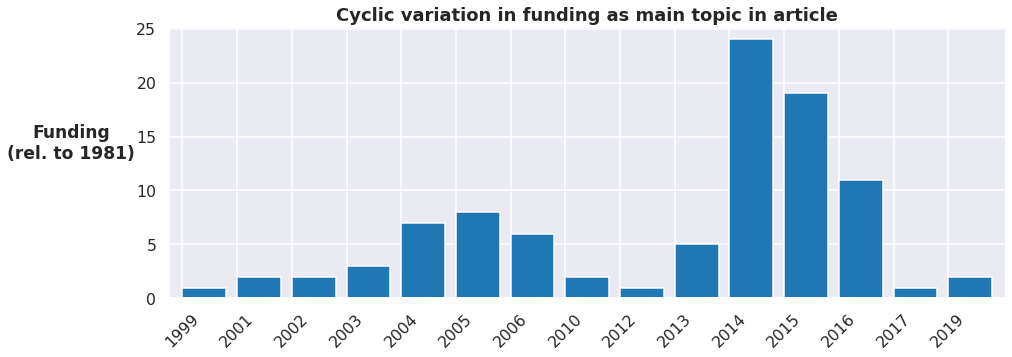

In [30]:
fig, ax = plt.subplots(figsize=(15, 5))
funds.plot(kind="bar", ax=ax, rot=45, align="edge", width=0.8)
ax.set_title(
    "Cyclic variation in funding as main topic in article",
    fontsize=18,
    fontweight="bold",
)
ax.set_xlabel(None)
h = plt.ylabel("Funding\n(rel. to 1981)", labelpad=65, fontweight="bold")
h.set_rotation(0)

**Observations**
1. The chart generally agrees with trends seen in other approaches - peaks in articles published occur in 2005 and a broader peak in news publications under this topic centered around the year 2014. The previously seen peak in 2007 does not appear here.
2. Although this topic was deemed present as one of the clusters, it is clear (from the weaker peak intensities and smaller number of years with documents) that this cluster is distinct from the topic found in the NMF/CorEx aproaches from the smaller number of years containing published articles assigned to this topic
   - as mentioned earlier, tuning hyperparametes of the TFIDF vectorizer, clustering model and truncated SVD is warranted

<a id="conclusions"></a>

## 6. [Conclusions](#conclusions)

**Limitations and Future Work**
1. Two out of fifteen topics found using the NLP (NMF) and CorEx approaches are likely being merged here in terms of clusters. The terms in the other topics appear to lie in clusters here that are distinctly separated from eachother. The optimal number of clusters should be investigated in order to explore `KMeans`' performance as a smaller or larger number of clusters are allowed. This could be compared to the pre-determined choice of 15 clusters used here in and also to the NLP approaches in earlier notebooks.
2. When compared to the NMF/CorEx approaches, since the only changes were replacement of an NLP step by clustering or LSA+clustering step, this would suggest that hyperparameters of the newly added steps need tuning. This should be pursued in combination with optimizing hyperparameters of each other step in the pipeline - TFIDF vectorization and (optionally) LSA - as their values for clustering analysis may not necessarily be the same as those used in NLP approaches.
4. LSA is helpful to facilitate dimensionality reduction of the TFIDF feature matrix, but could require tuning in order to extract clearly separable clusters that match topics found using NLP techniques (NMF/CorEx). This should be explored in combination with the `max_features` input argument of the TFIDF vectorizer.